## K-Means with Text Data

Sometime in January earlier this year, I wrote my first clustering application. For the given problem at hand, I was driven to find out 'similar looking' days in terms of solar irradiation. Meaning, I had to group days that had similar looking solar radiation profiles, temporal & amplitude both. I quickly acquired the dataset from a colleague, spent a few hours cleaning/preparing a time-series of 24 hours and finally faced the big question: How do I group these days? That was my introduction to clustering. In this post, I will use one of the most popular clustering algorithms K-Means! And I will work on text data, grouping similar Wikipedia articles.

### Two aspects of clustering algorithms: Representation & Similarity

#### Representation:  What does text data look like?
The algorithm doesn't understand text data.

#### Similarity: What do you mean by 'similar articles'? How are two objects similar or dissimilar?
Distance metric for comparing how 'similar' or 'near' two articles are.


In [138]:
import sframe                                                  # see below for install instruction
import matplotlib.pyplot as plt                                # plotting
import numpy as np                                             # dense matrices
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.preprocessing import normalize                    # normalizing vectors
from sklearn.metrics import pairwise_distances                 # pairwise distances
import sys      
import os
%matplotlib inline

## Preprocessing text data: Extract TFIDF features

Clustering algorithms can be used on any kind of data (text, image, numerical etc) in order to identify groups with similar properties with respect to a metric. For any clustering algorithm two aspects need to be mentioned explicitly, **representation** and **similarity metric**. 

### Representation

Text files, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. So in order to work with text data, we must first convert the documents into numerical features. I will compute TF-IDF features vectors for each article.

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
import zipfile
import pandas as pd

zf = zipfile.ZipFile('./people_wiki.csv.zip')
df = pd.read_csv(zf.open('people_wiki.csv'))
vectorizer = TfidfVectorizer(min_df=1)
tf_idf = vectorizer.fit_transform(df['text'])


In [140]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']

    return csr_matrix( (data, indices, indptr), shape)

tf_id = load_sparse_csr('./people_wiki_tf_idf.npz')
tf_id

<59071x547979 sparse matrix of type '<type 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

## Normalization

Since we want to form natural cluster of documents with 'similar content' it doesn't make sense for us to use Euclidean distance since it wrongly penalizes longer documents. Therefore, normalization is essential.

### Similarity Metric
A normalized euclidean distance

In [141]:
tf_idf = normalize(tf_idf)

## K-means Algorithm

After picking K random data points are cluster centroids, the algorithm iterates between two steps.
1. Assign cluster to closest centroid.
2. Recompute the centroid (mean) of all the data points.

In [152]:
from sklearn.metrics import pairwise_distances

def get_centroids(data, k, seed=None):    
    print seed
    if seed is not None:
        np.random.seed(seed)
    n = data.shape[0]
    rand_indices = np.random.randint(0, n, k)
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [143]:
centroid = tf_idf[0:3,:]
distances = pairwise_distances(tf_idf, centroid).tolist()

dist = pairwise_distances(tf_idf[430,:], centroid[1,:])
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

closest_cluster = np.argmin(pairwise_distances(tf_idf, centroid), axis=1)
print closest_cluster
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass
[0 1 2 ..., 0 0 0]
Pass


In [144]:
def assign_clusters(data, centroids):
    
    distance_from_centroids = pairwise_distances(data, centroids)
    cluster_assignment = np.argmin(distance_from_centroids, axis=1)
    return cluster_assignment


In [145]:
print 'data:\n', tf_idf[0:100:10].shape
print '\ncentroids:\n', tf_idf[0:8:2].shape
print '\ndistances:\n',pairwise_distances(tf_idf[0:100:10], tf_idf[0:8:2])
print 'shape:', pairwise_distances(tf_idf[0:100:10], tf_idf[0:8:2]).shape
print np.argmin(pairwise_distances(tf_idf[0:100:10], tf_idf[0:8:2]), axis=1)

data:
(10, 548429)

centroids:
(4, 548429)

distances:
[[ 0.          1.33283521  1.38491571  1.37761454]
 [ 1.36906121  1.37632795  1.38740457  1.3880518 ]
 [ 1.34181353  1.32512254  1.36871379  1.37116954]
 [ 1.32961915  1.36347792  1.38574025  1.38528546]
 [ 1.33754956  1.35581639  1.38247922  1.38012103]
 [ 1.34748457  1.35499333  1.35963943  1.36688704]
 [ 1.33282775  1.35398     1.38162293  1.37755153]
 [ 1.36916744  1.37947429  1.39028248  1.39030048]
 [ 1.35128553  1.37144896  1.38339973  1.3856312 ]
 [ 1.36876859  1.3804238   1.39584069  1.39464072]]
shape: (10, 4)
[0 0 1 0 0 0 0 0 0 0]


### Recompute Cluster Assignments

Filtering using boolean masks. 

In [146]:
def revise_centroids(data, k, assignment):
    new_centroids = []
    for k in range(k):
        member_of_cluster = data[assignment==k,:]
        centroid = member_of_cluster.mean(axis=0)
        
        centroid = centroid.A1 #WTF?
        
        new_centroids.append(centroid)
    
    new_centroids = np.array(new_centroids)
    return new_centroids

### Assess Convergence: Hetereogeneity

In [149]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in xrange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [129]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    
    '''Input: data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
       
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and (prev_cluster_assignment==cluster_assignment).all():
            print 'converged in', itr+1
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('{0:5d} elements changed their cluster assignment.'.format(num_changed))   
         
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment, record_heterogeneity

In [130]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
 3232 elements changed their cluster assignment.
2
 4017 elements changed their cluster assignment.
3
 4346 elements changed their cluster assignment.
4
 3062 elements changed their cluster assignment.
5
 2206 elements changed their cluster assignment.
6
 1546 elements changed their cluster assignment.
7
 1104 elements changed their cluster assignment.
8
  792 elements changed their cluster assignment.
9
  621 elements changed their cluster assignment.
10
  512 elements changed their cluster assignment.
11
  414 elements changed their cluster assignment.
12
  372 elements changed their cluster assignment.
13
  280 elements changed their cluster assignment.
14
  215 elements changed their cluster assignment.
15
  193 elements changed their cluster assignment.
16
  161 elements changed their cluster assignment.
17
  110 elements changed their cluster assignment.
18
   78 elements changed their cluster assignment.
19
   55 elements changed their cluster assignment.
20
   46 elements c

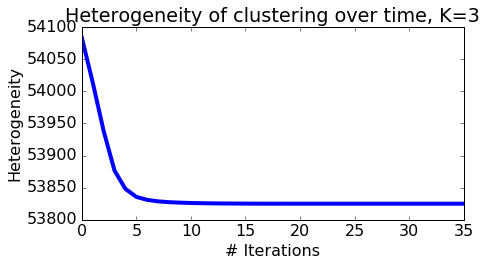

In [135]:
k = 3
heterogeneity = []
initial_centroids = get_centroids(tf_idf, k, seed=0)
centroids, cluster_assign, heterogeneity = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

#### Count number of elements in each cluster: np.bincounts or df['cluster'].value_counts()

In [147]:
print np.bincount(cluster_assign)
print cluster_assign

[35432 23239   400]
[0 0 0 ..., 0 0 1]


### Beware of local minima - Seeding KMeans

In [ ]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    
    initial_centroids = get_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400, record_heterogeneity=None, verbose=False)
    
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
    
end = time.time()
print(end - start)